In [1]:
from sdm.utils.io import set_project_wd
set_project_wd()

Current Working Directory: /Users/work/Data Science/sheffield-bats


In [2]:
%load_ext autoreload
%autoreload 2

import json

import elapid as ela
import geopandas as gpd
import rioxarray as rxr

from sklearn.metrics import roc_auc_score
from folium import Map, GeoJson, CircleMarker

# Updated imports from sdm library
from sdm.models.utils.utils import prepare_occurrence_data
from sdm.models.maxent.maxent_model import evaluate_and_train_maxent_model
from sdm.raster.io import load_environmental_variables
from sdm.raster.utils import generate_point_grid
from sdm.occurrence.species_data import latin_name, activity_type, genus
from sdm.utils.io import load_config
from sdm.utils.io import load_boundary

from pathlib import Path

In [3]:
# load the config
config = load_config()
config


{'paths': {'raw_data': 'data/raw',
  'processed_data': 'data/processed',
  'models': 'data/sdm_models',
  'predictions': 'data/sdm_predictions',
  'occurence_data': 'data/processed/bats-tidy.geojson',
  'background_points': 'data/processed/background-points.geojson',
  'boundary': 'data/processed/boundary.geojson',
  'grid_points': 'data/evs/grid-points.parquet',
  'evs': 'data/processed/evs',
  'ev_tiff': 'data/evs/evs-to-model.tif'},
 'crs': 'EPSG:27700',
 'mlflow': {'tracking_uri': 'sqlite:///data/sdm_models/mlflow.db',
  'experiment_name': 'species_sdm_experiment'},
 'hyperparameters': {'maxent': {'regularization_multiplier': 1.0}}}

In [4]:
import topojson as tp

boundary = load_boundary(filepath=config["paths"]["boundary"], buffer_distance=0, target_crs=27700)

# simplify the boundary to regions to make the calculation faster
boundary_tp = tp.Topology(boundary, prequantize=True)
boundary_tp.toposimplify(100, inplace=True)
boundary = boundary_tp.to_gdf()
boundary["geometry"] = boundary.geometry.make_valid()
boundary["geometry"] = boundary.geometry.buffer(0)


boundary_4326 = boundary.to_crs(4326)
boundary_4326

,geometry,County
0,"MULTIPOLYGON (((-0.92927 53.77354, -0.93328 53...",East Riding of Yorkshire
1,"MULTIPOLYGON (((-0.78862 54.56019, -0.78826 54...",North Yorkshire
2,"POLYGON ((-1.82224 53.52109, -1.80427 53.537, ...",South Yorkshire
3,"POLYGON ((-1.82224 53.52109, -1.82714 53.52349...",West Yorkshire


# Load the Occurence

In [5]:
grid_points = gpd.read_parquet(config["paths"]["grid_points"])

grid_points.head()

,geometry
10581,POINT (449350 372150)
10582,POINT (449450 372150)
10583,POINT (449550 372150)
10584,POINT (449650 372150)
10585,POINT (449750 372150)


In [6]:
latin_name = "Myotis daubentonii"
activity_type = "In flight"


# load the occurrence data
all_occurences = gpd.read_file(config["paths"]["occurence_data"])
all_occurences = all_occurences[all_occurences.accuracy <= 100]

bats = all_occurences[
    (all_occurences.latin_name == latin_name)
    & (all_occurences.activity_type == activity_type)
]

print(f"Loaded {len(bats)} points for {latin_name} - {activity_type}")


from leafmap.deckgl import Map

map_center = boundary_4326.union_all().centroid
m = Map(
    center=(map_center.y, map_center.x),
    zoom=7
)

m.add_gdf(
    boundary,
    zoom_to_layer=False,
    get_fill_color=[60, 60, 60, 40],
) 

m.add_gdf(
    all_occurences,
    zoom_to_layer=False,
    get_radius=500,
    # pink
    get_fill_color=[255, 192, 203, 180],
)

m


Loaded 441 points for Myotis daubentonii - In flight


Map(custom_attribution='', layers=(SolidPolygonLayer(get_fill_color=[60, 60, 60, 40], table=arro3.core.Table
+…

In [7]:



from sdm.occurrence.sampling import generate_background_points_from_data, BackgroundMethod, TransformMethod
## This is too slow 
# TODO: make it faster

# geenrate the background points
background, density_array = generate_background_points_from_data(
    occurrence_data=all_occurences,
    boundary=boundary,
    regions=boundary,
    n_background_points=1000,
    background_method=BackgroundMethod.CONTRAST,
    background_value=0.0,
    sigma=1.0,
    transform_method=TransformMethod.PRESENCE,
    region_weighting_factor=0.01,
    clip_to_boundary=False,
)



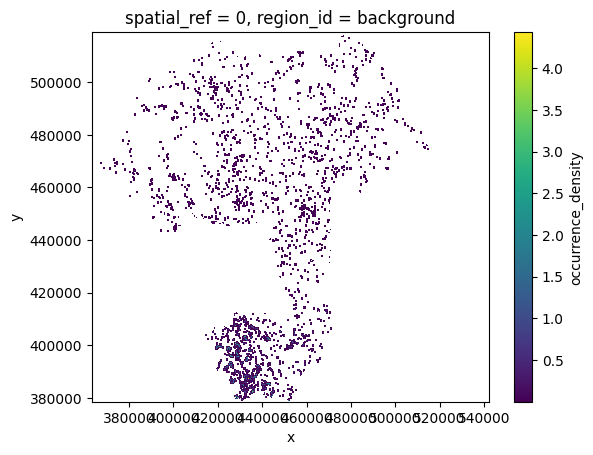

In [8]:
density_array.where(density_array > 0.0).plot()

In [9]:
# use leafmap foliumap to plot the map
from leafmap.foliumap import Map
from folium import GeoJson, CircleMarker




centroid = boundary_4326.union_all().centroid
m = Map(
    location=[centroid.y, centroid.x],
    zoom_start=8,
    tiles='CartoDB positron'
)

# Add boundary
GeoJson(
    boundary,
    style_function=lambda x: {'fillColor': 'none', 'color': 'black'}
).add_to(m)



# Add background points
GeoJson(
    background,
    style_function=lambda x: {'fillColor': 'pink', 'color': 'pink', 'radius': 3, 'fillOpacity': 0.5, 'weight': 0.5},
    marker=CircleMarker(radius=3)
).add_to(m)

# Add bats points
GeoJson(
    bats[["geometry"]],
    style_function=lambda x: {'color': '#9d76db', 'radius': 4, 'weight': 2, 'fillOpacity': 0.5},
    marker=CircleMarker(radius=3)
).add_to(m)

m


In [41]:
bats.activity_type.unique()

array(['In flight'], dtype=object)

# Environmental Variables

In [42]:
evs_to_model, ev_path = load_environmental_variables(config["paths"]["ev_tiff"])

evs_to_model

<xarray.Dataset> Size: 513MB
Dimensions:                                  (x: 1930, y: 1544)
Coordinates:
  * x                                        (x) float64 15kB 3.562e+05 ... 5...
  * y                                        (y) float64 12kB 3.716e+05 ... 5...
    spatial_ref                              int64 8B 0
Data variables: (12/43)
    climate_stats_temp_ann_var               (y, x) float32 12MB ...
    climate_bioclim_bio_7                    (y, x) float32 12MB ...
    terrain_dtm                              (y, x) float32 12MB ...
    climate_stats_prec_ann_avg               (y, x) float32 12MB ...
    climate_stats_temp_ann_avg               (y, x) float32 12MB ...
    ceh_landcover_wetland                    (y, x) float32 12MB ...
    ...                                       ...
    vom_vegetation_height_mean_500m          (y, x) float32 12MB ...
    ceh_landcover_suburban_500m              (y, x) float32 12MB ...
    os_cover_water_500m                      (y, x) float32 12MB ...
    ceh_landcover_coniferous_woodland_500m   (y, x) float32 12MB ...
    ceh_landcover_urban_500m                 (y, x) float32 12MB ...
    ceh_landcover_improved_grassland_500m    (y, x) float32 12MB ...
Attributes:
    AREA_OR_POINT:  Area

## Focal Stats

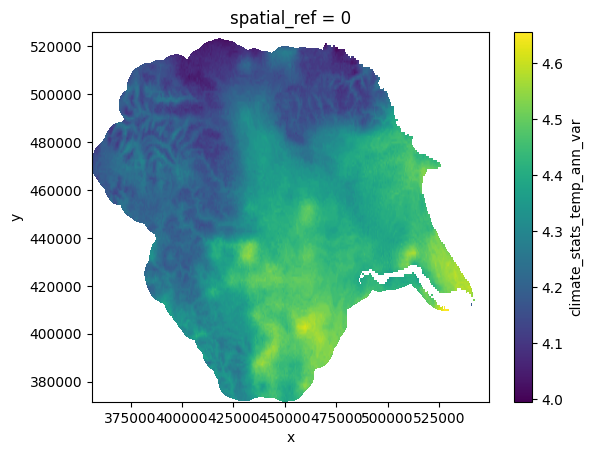

In [43]:
evs_to_model["climate_stats_temp_ann_var"].plot()

# Point Annotation

In [44]:
from sdm.data.processing import annotate_points

ev_columns = list(evs_to_model.data_vars.keys())

presence_annotated, background_annotated = annotate_points(bats, background, ev_raster=ev_path, ev_columns=ev_columns)


Raster:   0%|                              | 0/1 [00:00<?, ?it/s]

Sample:   0%|                              | 0/441 [00:00<?, ?it/s]

Raster:   0%|                              | 0/1 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2301 [00:00<?, ?it/s]

In [45]:

occurence_data = prepare_occurrence_data(
    presence_gdf=presence_annotated,
    background_gdf=background_annotated,
    background_density=background_annotated.density,
    grid_gdf=grid_points,
    input_vars=ev_columns,
    drop_na=True,
    sample_weight_n_neighbors=5,
    filter_to_grid=True
)

print(f"Number of presence points: {len(presence_annotated)}")
print(f"Number of background points: {len(background_annotated)}")

print(f"Total number of points: {len(occurence_data)}")

Number of presence points: 432
Number of background points: 2193
Total number of points: 2348


In [46]:
occurence_data.head()

,os_cover_water,terrain_stats_aspect_northness_slope,os_distance_distance_to_water,ceh_landcover_arable_500m,ceh_landcover_improved_grassland_500m,ceh_landcover_arable,ceh_landcover_wetland,ceh_landcover_grassland_500m,os_distance_distance_to_major_roads,climate_bioclim_bio_7,...,ceh_landcover_suburban_500m,terrain_stats_roughness,ceh_landcover_upland_heathland,os_distance_distance_to_buildings,ceh_landcover_urban,vom_vegetation_height_max,climate_bioclim_bio_3,ceh_landcover_urban_500m,sample_weight,class
0,0.0,-0.139881,357.454163,28.0,3154.0,0.0,0.0,0.0,775.229736,20.370117,...,6369.0,0.134950,0.0,40.838676,200.0,10.074518,38.444019,387.0,9.582984,1
1,11.0,0.018940,42.051125,34.0,1214.0,0.0,0.0,0.0,808.771606,19.473274,...,6534.0,0.316657,0.0,77.645851,0.0,21.954548,38.432117,634.0,9.841965,1
2,38.0,-1.360139,28.743666,43.0,1882.0,0.0,0.0,96.0,5111.471191,18.469063,...,255.0,0.111450,4500.0,217.248291,0.0,16.015003,38.127823,9.0,12.599773,1
3,45.0,-0.399579,250.177505,4626.0,3258.0,700.0,0.0,0.0,747.926636,18.630499,...,206.0,0.222426,0.0,109.792633,0.0,4.564459,39.208286,208.0,9.815881,1
4,45.0,-0.966461,206.310638,8.0,6540.0,0.0,0.0,82.0,4253.204102,18.900000,...,151.0,0.103181,0.0,98.603249,0.0,13.100911,37.169506,18.0,6.228109,1


# Modelling

In [47]:
len(occurence_data)

2348

In [48]:
from sdm.models.maxent.maxent_model import create_maxent_pipeline, get_feature_config, ActivityType
feature_config = get_feature_config()
features_to_model = feature_config[ActivityType.IN_FLIGHT]
maxent_model = create_maxent_pipeline(
    feature_names=features_to_model,
    maxent_n_jobs=-1,
)

maxent_model



Pipeline(steps=[('feature_selection',
                 FeatureSubsetter(feature_names=['ceh_landcover_improved_grassland',
                                                 'ceh_landcover_suburban',
                                                 'bgs_coast_distance_to_coast',
                                                 'ceh_landcover_arable',
                                                 'ceh_landcover_suburban_500m',
                                                 'ceh_landcover_arable_500m',
                                                 'climate_bioclim_bio_7',
                                                 'vom_vegetation_height_max',
                                                 'terrain_stats_slope',
                                                 'ceh_landcover_broadleaved_woodland'...
                                                 'climate_bioclim_bio_3',
                                                 'ceh_landcover_improved_grassland_500m',
                                                 'ceh_landcover_urban',
                                                 'climate_stats_prec_ann_avg',
                                                 'climate_stats_temp_ann_avg',
                                                 'os_distance_distance_to_major_roads',
                                                 'terrain_dtm',
                                                 'os_distance_distance_to_buildings',
                                                 'ceh_landcover_urban_500m',
                                                 'climate_stats_wind_ann_avg'])),
                ('scaling', StandardScaler()),
                ('maxent', MaxentModel(n_cpus=-1))])

In [49]:
import mlflow
def to_percent(x):
    return (x * 100).round(1)




mlflow.set_experiment(config["mlflow"]["experiment_name"])


with mlflow.start_run():
    final_model, cv_models, cv_scores = evaluate_and_train_maxent_model(
        model=maxent_model,
        occurrence_gdf=occurence_data,
        metric_fn=roc_auc_score,
        n_cv_folds=3,
        random_state_kfold=42
    )

    mlflow.log_metric("mean_auc", cv_scores.mean())
    mlflow.log_metric("std_auc", cv_scores.std())



    mlflow.log_params({
        "latin_name": latin_name,
        "activity_type": activity_type,
        "n_presence": len(presence_annotated),
        "n_background": len(background_annotated),
        "feature_names": features_to_model,
    })


print(f"Mean AUC: {to_percent(cv_scores.mean())}%")
print(f"Variation: +/- {to_percent(cv_scores.std())}%")

Mean AUC: 78.4%
Variation: +/- 4.2%


In [50]:
model_id = f"{latin_name}-{activity_type}"

In [51]:
from sdm.models.maxent.maxent_model import apply_models_to_raster
prediction_paths = []
# Define the arguments for each task

path_predict = Path(f"data/temp/prediction-{latin_name}-{activity_type}.tif")
path_predict.parent.mkdir(parents=True, exist_ok=True)

apply_models_to_raster(
    models={
        model_id: final_model,
    },
    raster_path=ev_path,
    output_path=str(path_predict),
    windowed=True,
    window_size=256,
)


Processing windows:   0%|                              | 0/56 [00:00<?, ?it/s]

In [37]:
from rasterio.mask import mask
import numpy as np  
import rasterio as rio
import rioxarray as rxr

# mask the prediction raster with the boundary
predictions_masked = Path(f"data/temp/prediction-{latin_name}-{activity_type}-masked.tif")

predictions = rxr.open_rasterio(path_predict)
predictions = predictions.rio.clip_box(*tuple(boundary.total_bounds))
predictions = predictions.rio.reproject(4326)
predictions.rio.to_raster(predictions_masked)

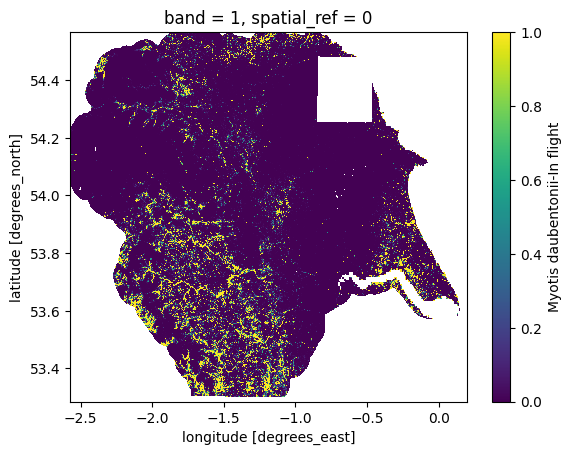

In [53]:
predictions.where(predictions > 0.0).plot()

In [38]:
import leafmap

m = leafmap.Map()
m.zoom_to_gdf(boundary_4326)
m.add_basemap("HYBRID")
m.add_raster(
    str(predictions_masked),
    layer_name="Predictions",
    cmap="viridis",
    nodata=np.nan,
    opacity=0.7,
)
m.add_gdf(
    occurence_data[occurence_data["class"] == 1],
    layer_name="Presence",
    point_style={"color": "orange", "weight": 1, "opacity": 0.7, "radius": 3},
)
m

Map(center=[53.9258685, -1.187851], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…